In [1]:
import sys
sys.path.insert(0, "/home/george/utility/fairseq")
sys.path.insert(0, "../")
%load_ext autoreload
%autoreload 2

In [2]:
from fairseq import (
    checkpoint_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from torchinfo import summary
import logging
import os
import torch

In [3]:
user_dir = "../codebase"
inference_config_yaml = "/home/george/Projects/attack-st/eval/config_attack.yaml"
checkpoint = "../exp/checkpoints/covost2_en_asr_transformer_s.pt"
use_cuda = True

states = checkpoint_utils.load_checkpoint_to_cpu(
    path=checkpoint, arg_overrides=None, load_on_all_ranks=False)
cfg = states["cfg"]
cfg.task.config_yaml = inference_config_yaml
cfg.common.user_dir = user_dir

In [4]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("fairseq_cli.train")

In [5]:
utils.import_user_module(cfg.common)

# Setup task, e.g., translation, language modeling, etc.
task = tasks.setup_task(cfg.task)
# Build model and criterion
model = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
logger.info(summary(model))
logger.info("task: {}".format(task.__class__.__name__))
logger.info("model: {}".format(model.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))

2021-12-11 21:19:18 | INFO | fairseq.tasks.speech_to_text | dictionary size (/media/george/Data/covost2-atk/en/external/spm_char.txt): 157
2021-12-11 21:19:19 | INFO | fairseq_cli.train | ===========================================================================
Layer (type:depth-idx)                             Param #
S2TTransformerModel                                --
├─S2TTransformerEncoder: 1-1                       --
│    └─FairseqDropout: 2-1                         --
│    └─Conv1dSubsampler: 2-2                       --
│    │    └─ModuleList: 3-1                        1,721,856
│    └─SinusoidalPositionalEmbedding: 2-3          --
│    └─ModuleList: 2-4                             --
│    │    └─TransformerEncoderLayer: 3-2           1,315,072
│    │    └─TransformerEncoderLayer: 3-3           1,315,072
│    │    └─TransformerEncoderLayer: 3-4           1,315,072
│    │    └─TransformerEncoderLayer: 3-5           1,315,072
│    │    └─TransformerEncoderLayer: 3-6        

In [6]:
logger.info("loading model(s) from {}".format(cfg.common_eval.path))
model = task.build_model(cfg.model)
model.load_state_dict(
    states["model"], strict=True, model_cfg=cfg.model
)

# Optimize ensemble for generation
if use_cuda:
#     model.half()
    model.cuda()
model.prepare_for_inference_(cfg)

2021-12-11 21:19:19 | INFO | fairseq_cli.train | loading model(s) from None


In [99]:
# Handle tokenization and BPE
# def decode(
#     tensor,
#     escape_unk=False,
#     unk_string=None,
#     include_eos=False,
#     separator=None,
# ):    
#     def token_string(i):
#         if i == task.tgt_dict.unk():
#             if unk_string is not None:
#                 return unk_string
#             else:
#                 return task.tgt_dict.unk_string(escape_unk)
#         else:
#             return task.tgt_dict[i]

#     sent = [token_string(i) for i in tensor]
#     return sent if separator is None else separator.join(sent)

pre_tokenizer = task.build_tokenizer(None)
bpe_tokenizer = task.build_bpe(None)
def decode(toks, escape_unk=False):
    s = task.tgt_dict.string(
        toks.int().cpu(),
        "sentencepiece",  # this will handle bpe for us.
        # The default unknown string in fairseq is `<unk>`, but
        # this is tokenized by sacrebleu as `< unk >`, inflating
        # BLEU scores. Instead, we use a somewhat more verbose
        # alternative that is unlikely to appear in the real
        # reference, but doesn't get split into multiple tokens.
        unk_string=("UNKNOWNTOKENINREF" if escape_unk else "UNKNOWNTOKENINHYP"),
    )
    if pre_tokenizer is not None:
        s = pre_tokenizer.decode(s)
    return s if s else "UNKNOWNTOKENINHYP"

2021-12-11 22:12:03 | INFO | fairseq.tasks.speech_to_text | pre-tokenizer: {'tokenizer': None}
2021-12-11 22:12:03 | INFO | fairseq.tasks.speech_to_text | tokenizer: {'bpe': 'sentencepiece', 'sentencepiece_model': '/media/george/Data/covost2-atk/en/external/spm_char.model'}


In [8]:
wav = "/home/george/Projects/attack-st/eval/data/wav/common_voice_en_18862286.wav"
sent = "The rhythm is typically played as a snare rim pattern in bossa nova music."
trans = "在博萨诺瓦音乐中，这种节奏通常以响弦边缘的形式演奏。"

In [9]:
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform
lines = [wav]
lengths = [get_features_or_waveform(p).shape[0] for p in lines]
tgt_texts = [sent]

In [101]:
from fairseq.data.audio.feature_transforms import (
    AudioFeatureTransform,
    CompositeAudioFeatureTransform,
    # register_audio_feature_transform,
)
from codebase.data.mytranforms import (
    UtteranceCMVNPyTorch,
    FBankPyTorch
)
from fairseq.data.audio.speech_to_text_dataset import SpeechToTextDataset


            


itr = task.get_batch_iterator(
    dataset=SpeechToTextDataset(
        "attack", False, task.data_cfg,
        lines, lengths, tgt_texts=tgt_texts, tgt_dict=task.tgt_dict,
        pre_tokenizer=task.build_tokenizer(None),
        bpe_tokenizer=task.build_bpe(None),
    ),
    max_sentences=1,
    max_positions=60000
).next_epoch_itr(shuffle=False)

input_transform = CompositeAudioFeatureTransform([
    FBankPyTorch(denormalize=True, num_mel_bins=80, sample_rate=48000),
    UtteranceCMVNPyTorch(norm_means=True, norm_vars=True)
])
logger.info(input_transform)

2021-12-11 22:13:02 | INFO | fairseq.tasks.speech_to_text | pre-tokenizer: {'tokenizer': None}
2021-12-11 22:13:02 | INFO | fairseq.tasks.speech_to_text | tokenizer: {'bpe': 'sentencepiece', 'sentencepiece_model': '/media/george/Data/covost2-atk/en/external/spm_char.model'}
2021-12-11 22:13:02 | INFO | fairseq.data.audio.speech_to_text_dataset | 'attack' has 0.00% OOV
2021-12-11 22:13:02 | INFO | fairseq.data.audio.speech_to_text_dataset | SpeechToTextDataset(split="attack", n_samples=1, prepend_tgt_lang_tag=False, shuffle=False, transforms=None, n_frames_per_step=1
2021-12-11 22:13:02 | INFO | fairseq_cli.train | CompositeAudioFeatureTransform(
    FBankPyTorch(denormalize=True, num_mel_bins=80, sample_rate=48000)
    UtteranceCMVNPyTorch(norm_means=True, norm_vars=True)
)


In [102]:
import torch.nn as nn
import math
from tqdm.auto import tqdm
@torch.no_grad()
def clamp(x_adv, x, epsilon, margin=1e-6):
    #     -31 [-45, -15]
    #     dB(x) = max i 20 · log10(xi)
    #     dBx(δ) = dB(δ) − dB(x)
    epsilon = x.abs() * (10 ** (epsilon / 20)) 
    tmp = x + (epsilon - margin)
    x_adv = torch.where(x_adv > tmp, tmp, x_adv)
    tmp = x - (epsilon - margin)
    x_adv = torch.where(x_adv < tmp, tmp, x_adv)
    return x_adv

def ensemble_logits(logits):
    """ expects list of unnormalized logits """
    N = len(logits)
    log_probs = [logit.log_softmax(-1) for logit in logits]
    avg_probs = torch.logsumexp(torch.stack(log_probs, dim=0), dim=0) - math.log(N)
    return avg_probs

def ifgsm(models, sample, loss_fn, epsilon=-31, alpha=1e-3, num_iter=1000):
    """ x is waveform, y is sequence """
    x = sample["net_input"]["src_tokens"]
    prev_y = sample["net_input"]["prev_output_tokens"]
    y = sample["target"]
    
    bar = tqdm(range(num_iter))
    x_adv = x.detach().clone()
    for i in bar:
        x_adv.requires_grad = True
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        
        src_tokens = torch.stack(
            [input_transform(t.unsqueeze(0)) for t in x_adv], dim=0)
        src_lengths = torch.LongTensor([src_tokens.size(1)]).type_as(prev_y)
        
        logits = []
        for model in models:
            logit, _ = model(src_tokens, src_lengths, prev_y)
            logits.append(logit)
        B, T = y.shape
        loss = loss_fn(ensemble_logits(logits).view(B*T, -1), y.view(B*T))
        loss.backward()
        # loss.backward(retain_graph=True)
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()
        x_adv = clamp(x_adv, x, epsilon)
        
        bar.set_postfix(loss=loss.item())
    return x_adv

for sample in itr:
    ids = sample["id"]
    sample = utils.move_to_cuda(sample)
    # ifgsm here
    wav_adv = ifgsm([model], sample, nn.CrossEntropyLoss(), epsilon=-31, alpha=1e-3, num_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [103]:
wav_ori = sample["net_input"]["src_tokens"]
wav_ori.shape, wav_adv.shape

(torch.Size([1, 241920]), torch.Size([1, 241920]))

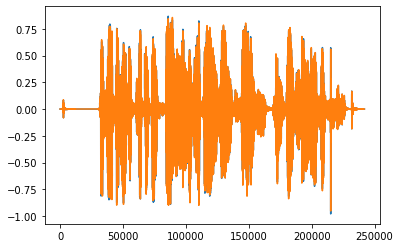

In [104]:
import matplotlib.pyplot as plt
plt.plot(wav_ori.squeeze().cpu().numpy())
plt.plot(wav_adv.squeeze().cpu().numpy())

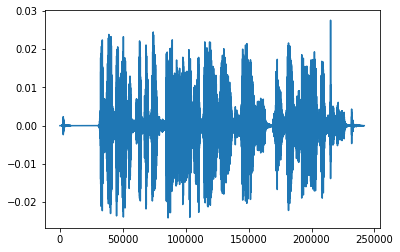

In [105]:
plt.plot((wav_adv - wav_ori).squeeze().cpu().numpy())

In [106]:
generator = task.build_generator(
    [model], cfg.generation
)

In [108]:
src_tokens = torch.stack(
    [input_transform(t.unsqueeze(0)) for t in wav_ori], dim=0)
src_lengths = torch.LongTensor([src_tokens.size(1)]).type_as(sample["target"])
sample["net_input"]["src_tokens"] = src_tokens
sample["net_input"]["src_lengths"] = src_lengths
hypos = task.inference_step(
    generator,
    [model],
    sample
)
decode(hypos[0][0]['tokens'])

/home/george/utility/fairseq/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/george/utility/fairseq/fairseq/sequence_generator.py:658: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


In [111]:
src_tokens = torch.stack(
    [input_transform(t.unsqueeze(0)) for t in wav_adv], dim=0)
src_lengths = torch.LongTensor([src_tokens.size(1)]).type_as(sample["target"])
sample["net_input"]["src_tokens"] = src_tokens
sample["net_input"]["src_lengths"] = src_lengths
hypos = task.inference_step(
    generator,
    [model],
    sample
)
decode(hypos[0][0]['tokens'])

'The realimist Dubby played on the sneer-round Helprin and Poatson of Whitlerseck.'